In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

In [2]:
cust_df=pd.read_csv('olist_customers_dataset.csv')
geo_df=pd.read_csv('olist_geolocation_dataset.csv')
ord_it_df=pd.read_csv('olist_order_items_dataset.csv')
ord_pay_df=pd.read_csv('olist_order_payments_dataset.csv')
ord_rev_df=pd.read_csv('olist_order_reviews_dataset.csv')
ord_df=pd.read_csv('olist_orders_dataset.csv')
prod_df=pd.read_csv('olist_products_dataset.csv')
sell_df=pd.read_csv('olist_sellers_dataset.csv')

In [3]:
dfs = {0:cust_df,1:geo_df,2:ord_it_df,3:ord_pay_df,4:ord_rev_df,5:ord_df,6:prod_df,7:sell_df}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-n

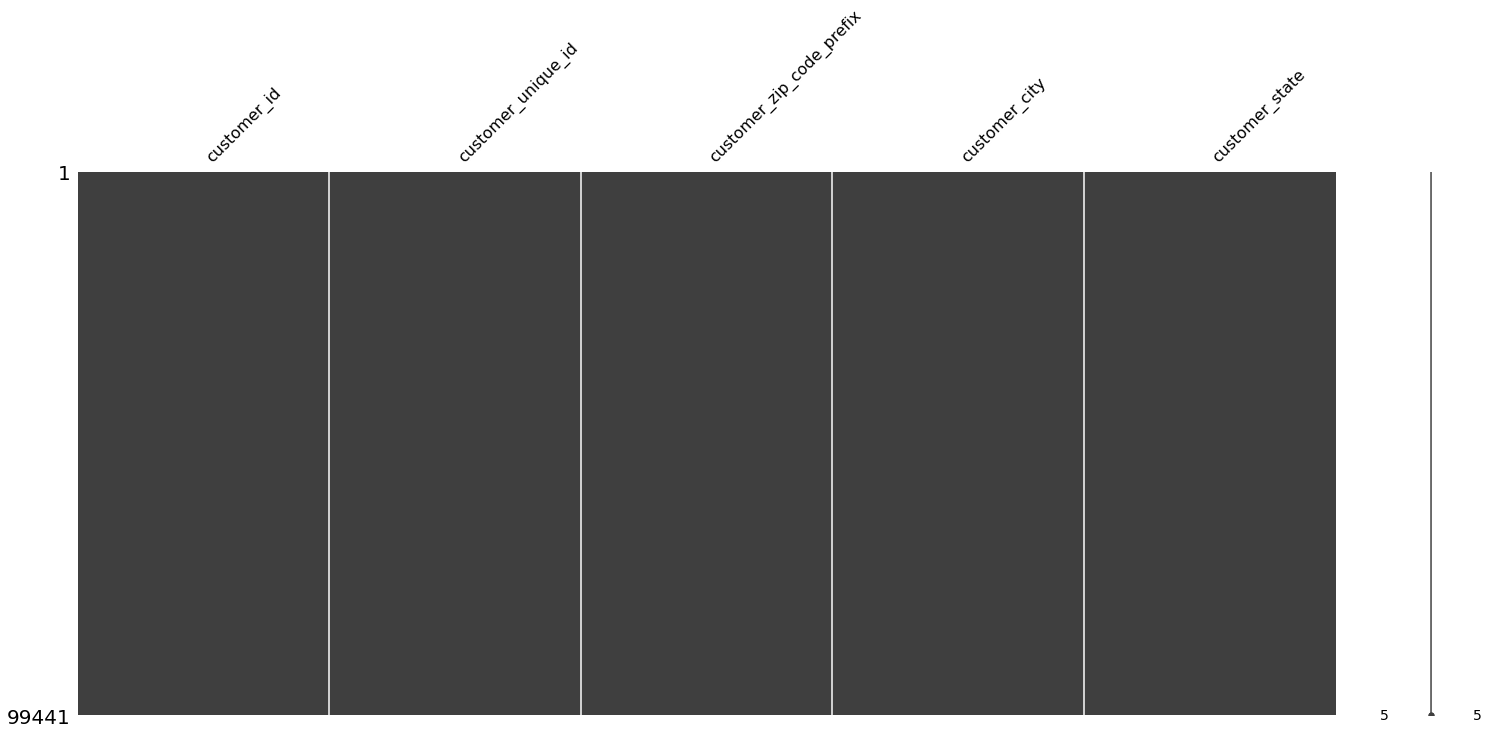

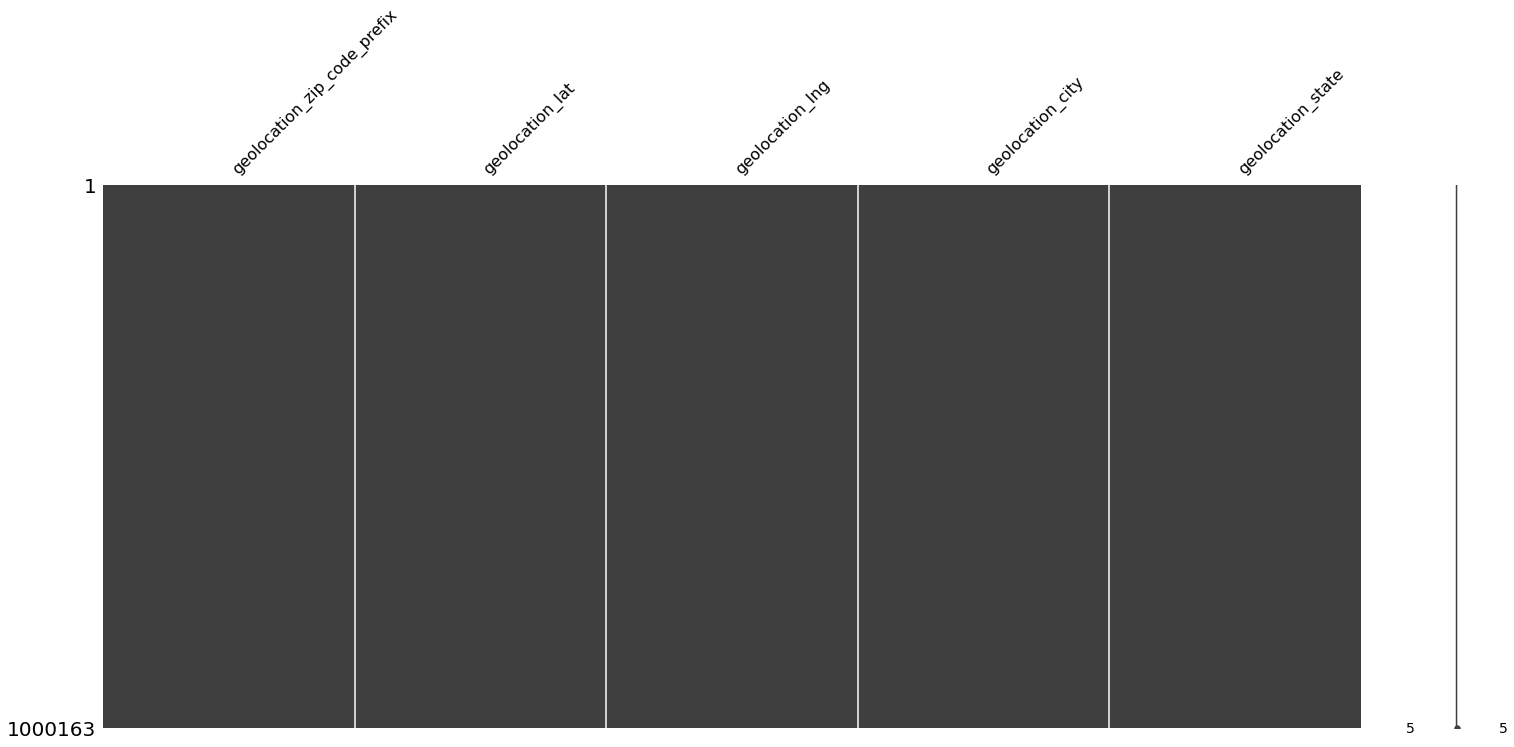

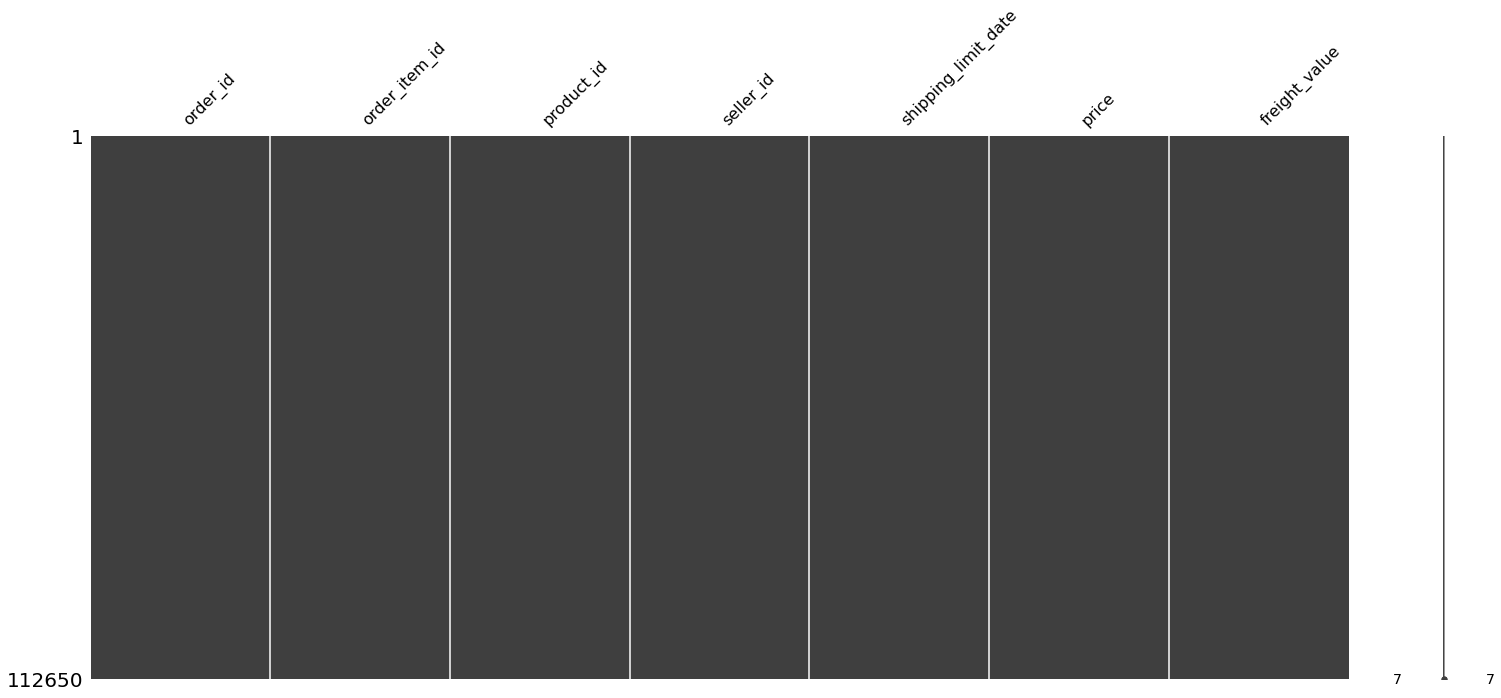

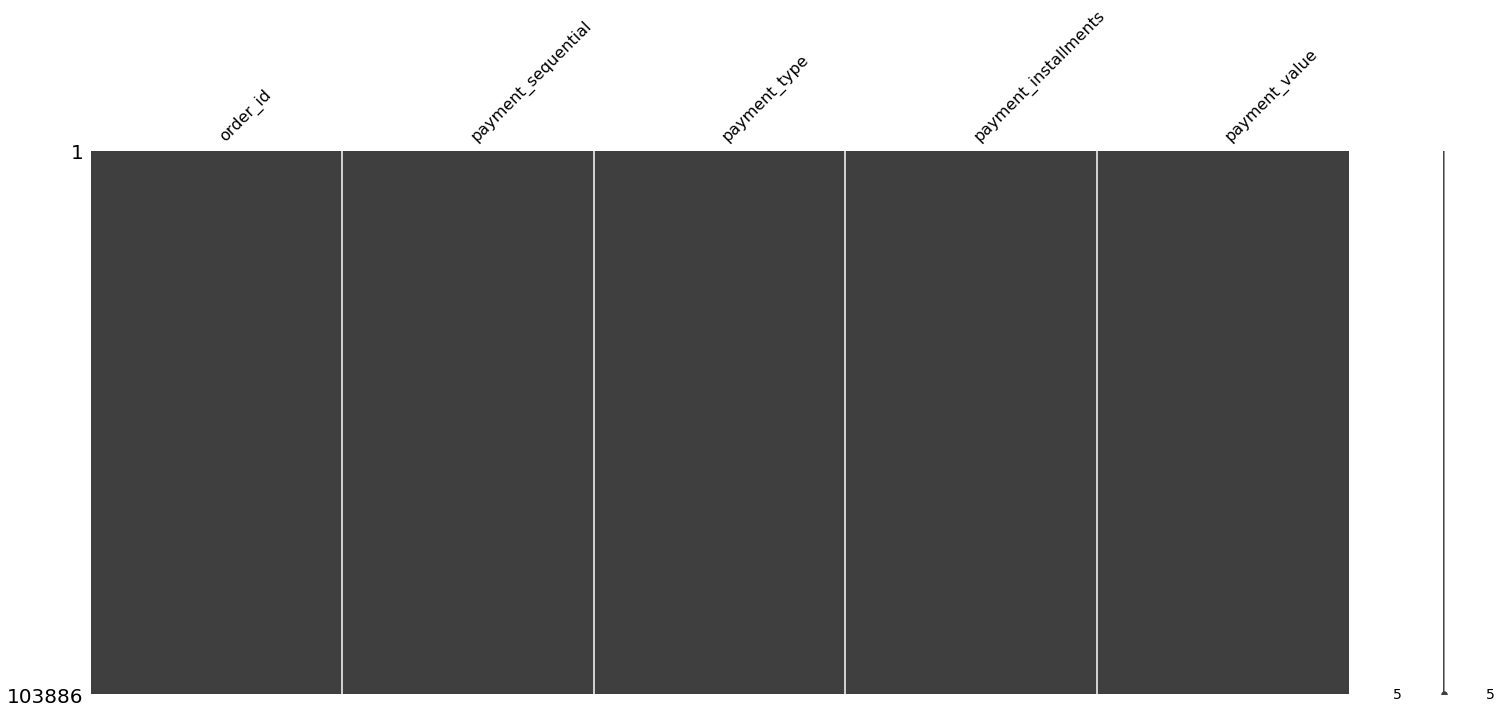

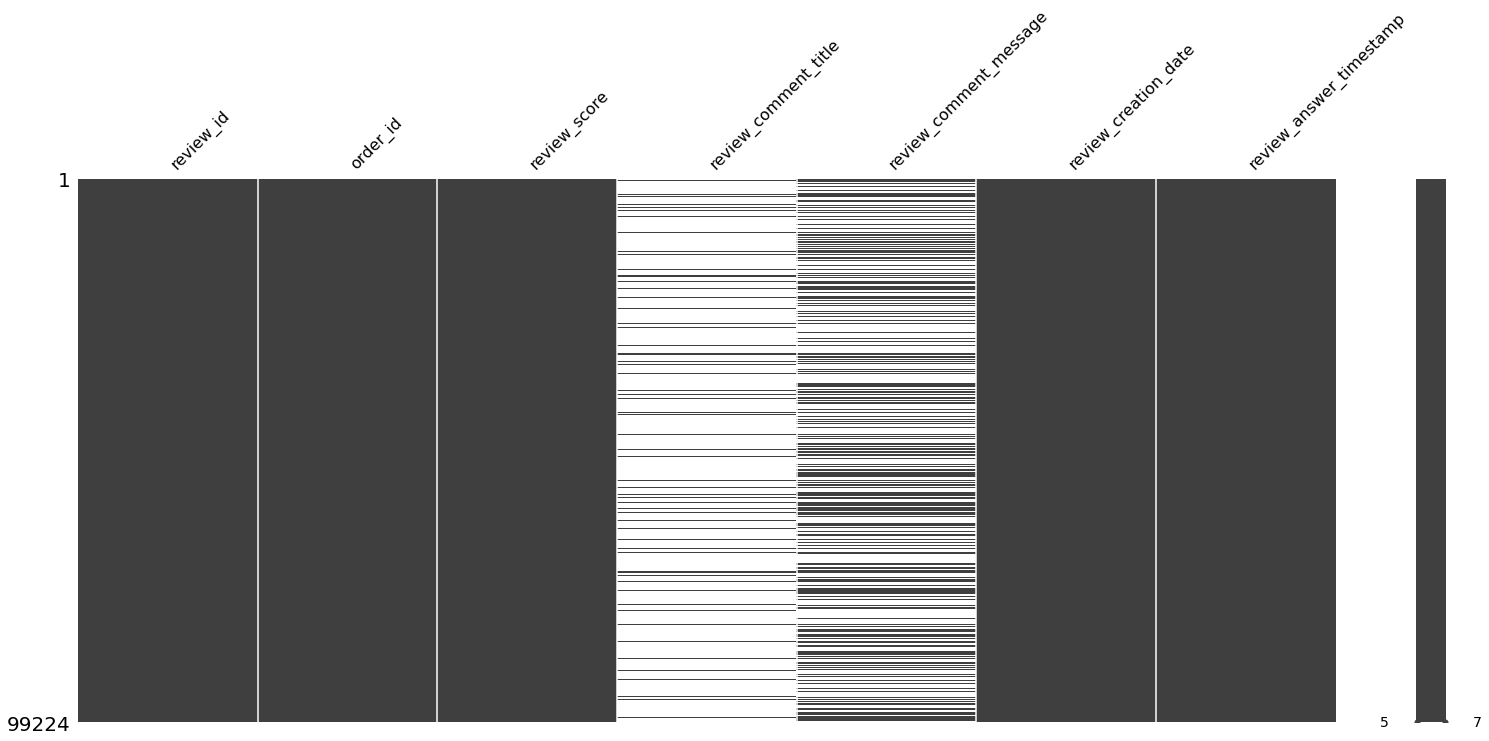

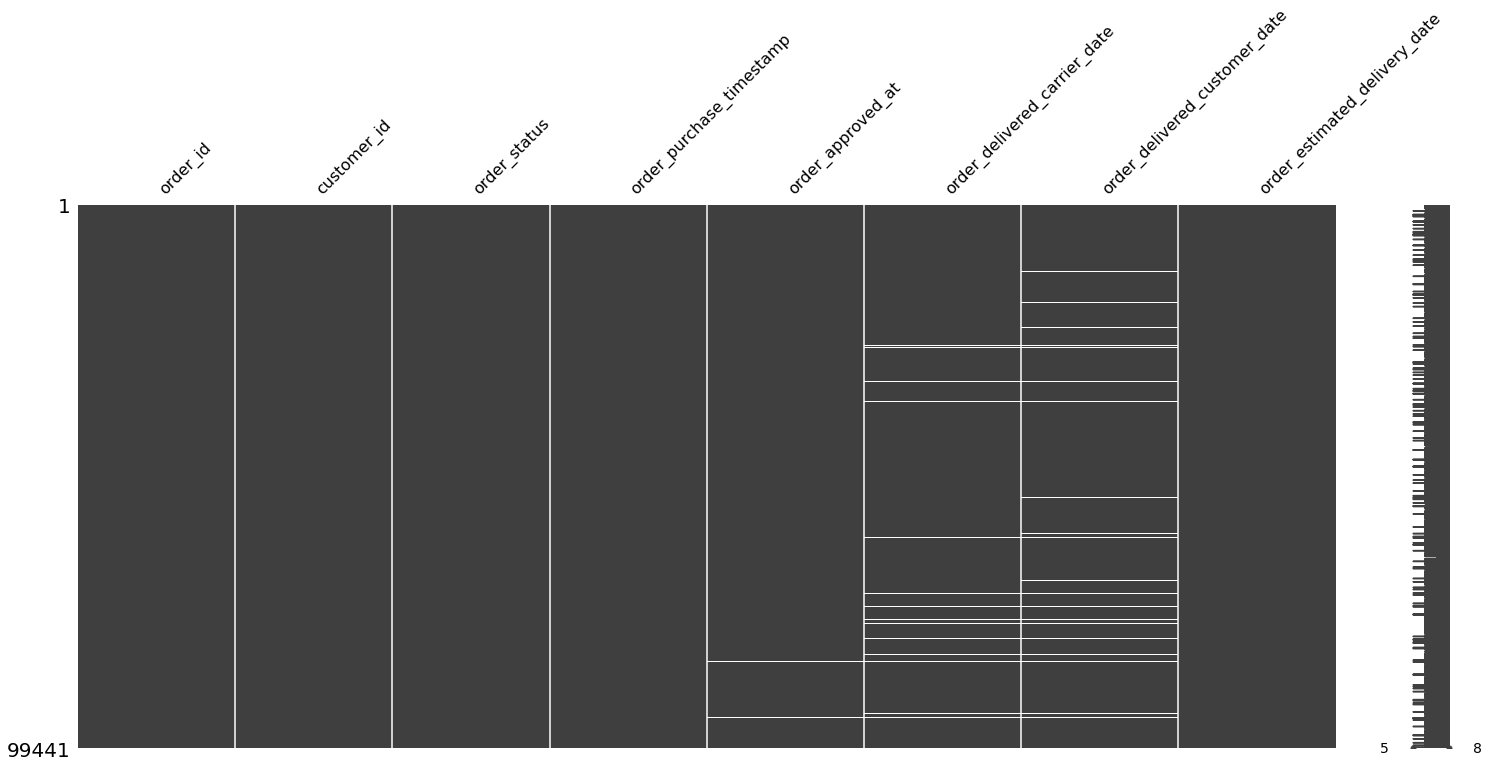

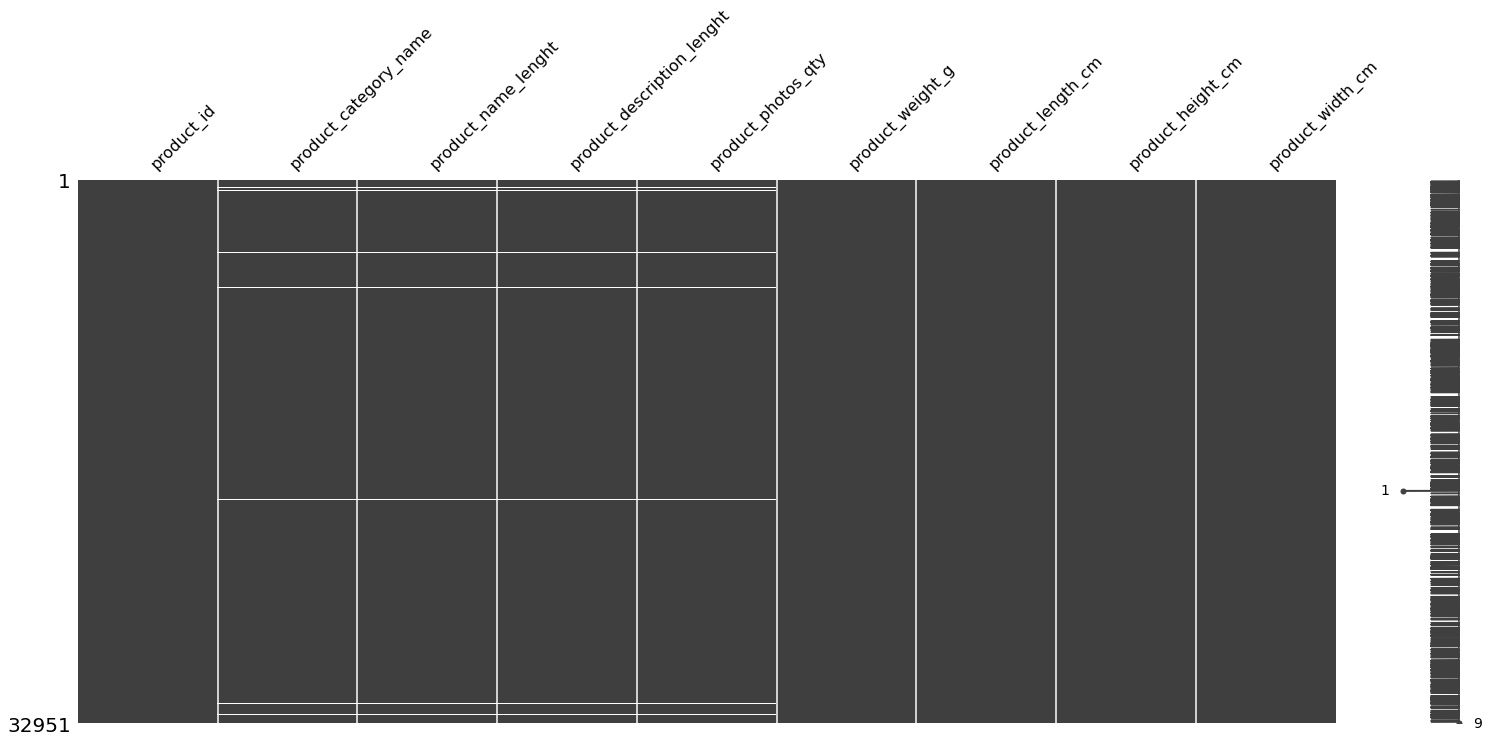

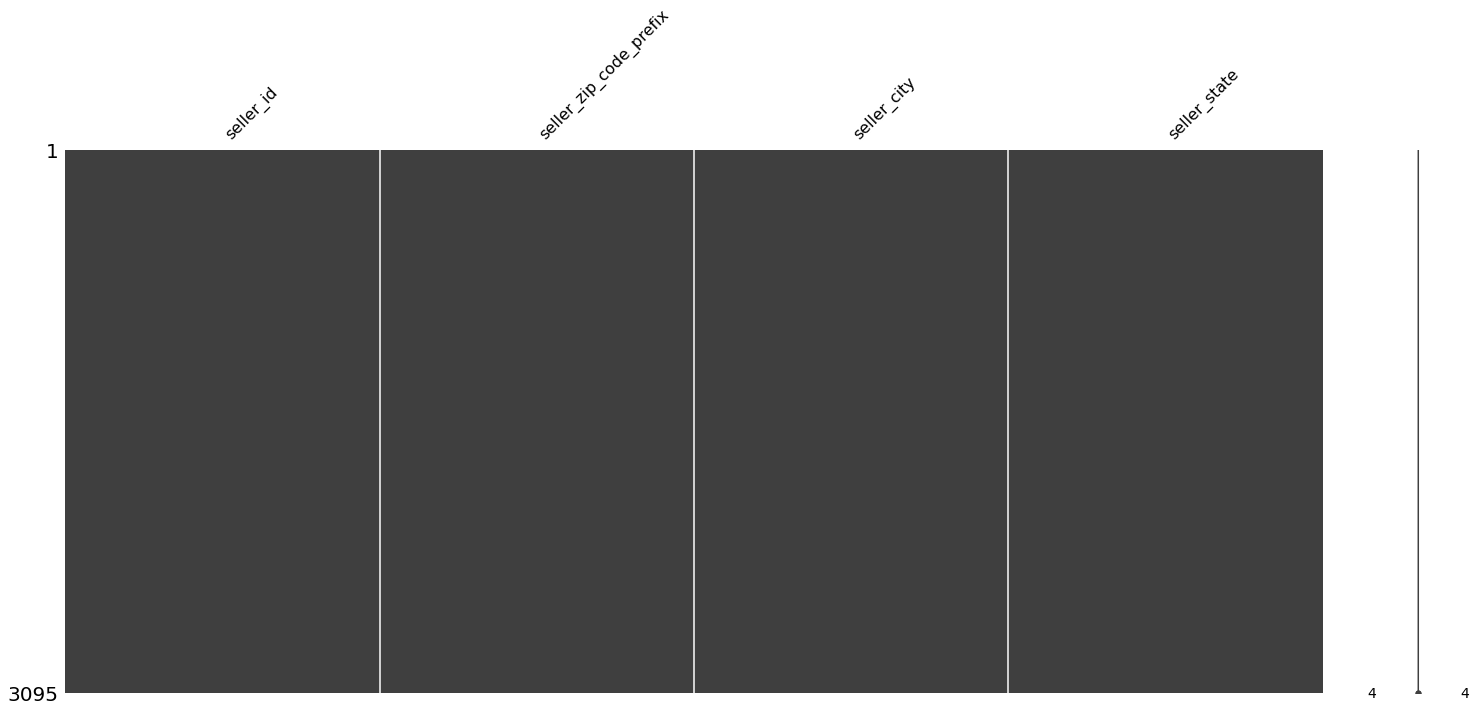

In [4]:
for i in dfs:
    print(dfs[i].info())
    msno.matrix(dfs[i])

In [7]:
#get the customers that ordered more than once
multi_cust_df = dfs[0][dfs[0].groupby('customer_unique_id').customer_unique_id.transform('count') > 1]

#get their customer_id
multi_custom = multi_cust_df[['customer_id','customer_unique_id']]
multi_id = multi_custom['customer_id']
multi_uni_id = multi_custom['customer_unique_id']
#get their order_id
multi_order_df = dfs[5][dfs[5]['customer_id'].isin(multi_id)]
multi_order_id = multi_order_df['order_id']

multi_pay_df = dfs[3][dfs[3]['order_id'].isin(multi_order_id)]



In [8]:
print(dfs[0]['customer_id'].unique().shape[0])
print(dfs[0]['customer_unique_id'].unique().shape[0])

99441
96096


In [9]:
import time
import datetime

def days(x):
    td = time.time()
    t = time.mktime(datetime.datetime.strptime(str(x),"%Y-%m-%d %H:%M:%S").timetuple())
    d = int((td - t)/86400)
    return d

In [10]:
#build the working df
df = pd.DataFrame(multi_custom)
df = df.set_index('customer_id')
df = df.join(multi_order_df[['customer_id','order_id', 'order_purchase_timestamp']].set_index('customer_id'))
temp = pd.DataFrame()
temp['order_total'] = multi_pay_df.groupby('order_id').payment_value.sum()
df = df.join(temp, on = 'order_id')
df['days_since_order'] = df['order_purchase_timestamp'].apply(days)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6342 entries, 879864dab9bc3047522c92c82e1212b8 to d9110683c7a282144e9fc97660026a28
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_unique_id        6342 non-null   object 
 1   order_id                  6342 non-null   object 
 2   order_purchase_timestamp  6342 non-null   object 
 3   order_total               6342 non-null   float64
 4   days_since_order          6342 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 555.3+ KB
None


In [11]:
#build the model df
md_df = pd.DataFrame(index = df['customer_unique_id'].unique())
md_df['n_order'] = df.groupby('customer_unique_id').order_id.count()
md_df['payment_total'] = df.groupby('customer_unique_id').order_total.agg('sum')
md_df['days_since_last_order'] = df.groupby('customer_unique_id').days_since_order.agg('min')

print(md_df.info(),md_df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 2997 entries, 4c93744516667ad3b8f1fb645a3116a4 to da29b8a3970adddb9ed2dc8a492065af
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   n_order                2997 non-null   int64  
 1   payment_total          2997 non-null   float64
 2   days_since_last_order  2997 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 93.7+ KB
None                                   n_order  payment_total  \
4c93744516667ad3b8f1fb645a3116a4        2         565.88   
1175e95fb47ddff9de6b2b06188f7e0d        2          83.19   
295c05e81917928d76245e842748184d        2         281.50   
e9dd12dca17352644a959d9dea133935        2         113.83   
e079b18794454de9d2be5c12b4392294        2         437.78   

                                  days_since_last_order  
4c93744516667ad3b8f1fb645a3116a4                   1859  
1175e95fb47ddff9de6b2b06188f7e0d              

<AxesSubplot:>

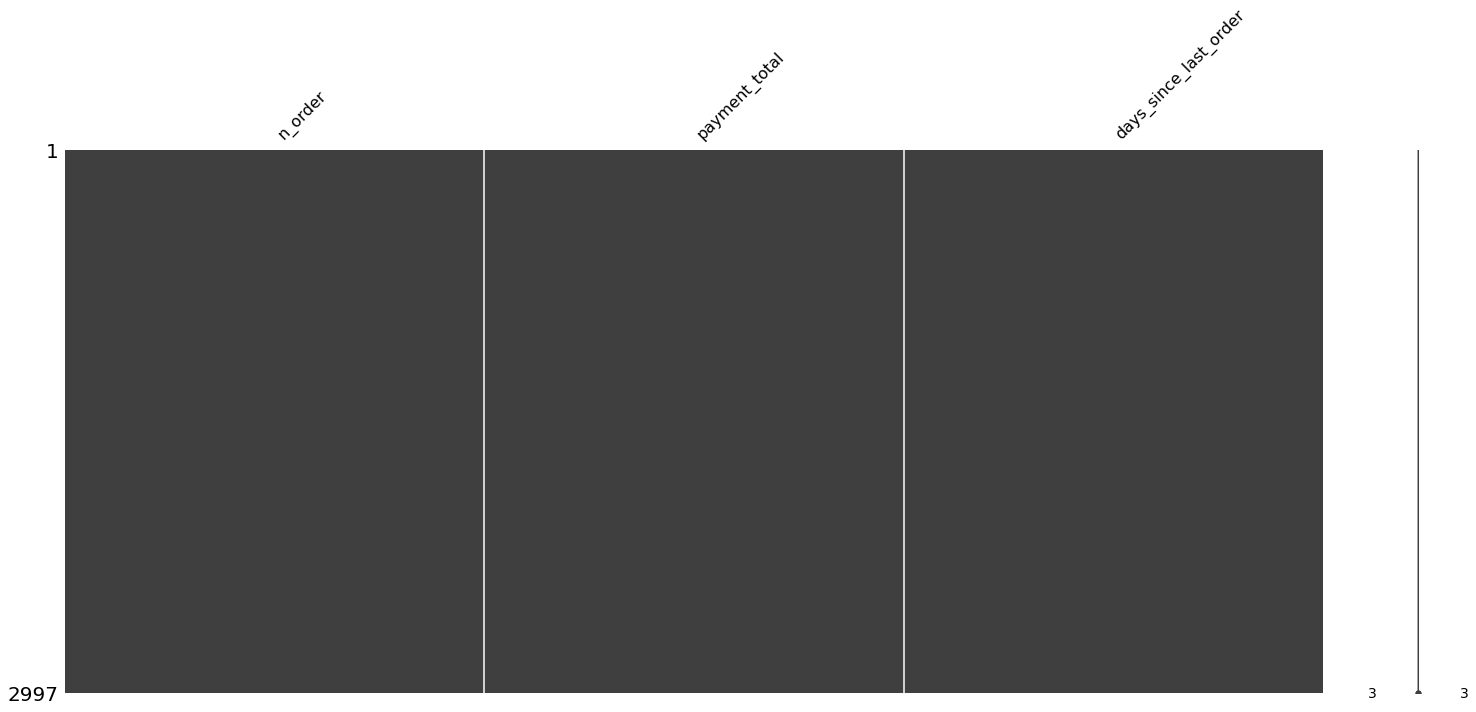

In [12]:
msno.matrix(md_df)

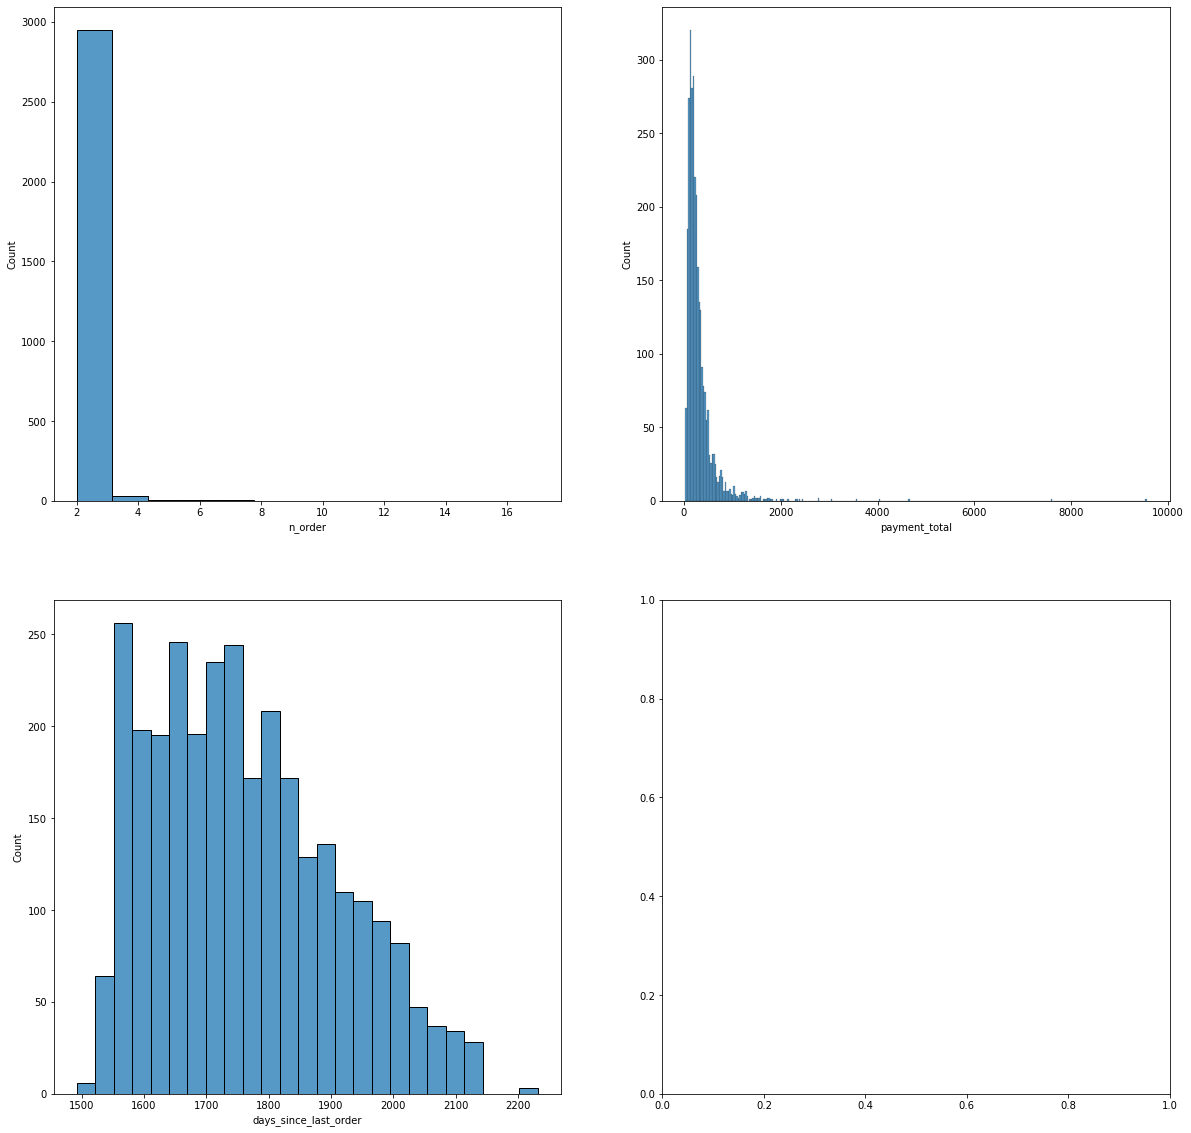

In [13]:
fig,ax = plt.subplots(2,2, figsize=(20,20))
sns.histplot(md_df.iloc[:,0], ax = ax[0,0])
sns.histplot(x=md_df.iloc[:,1], ax = ax[0,1])
sns.histplot(x=md_df.iloc[:,2], ax = ax[1,0])
plt.show()

In [14]:
md_df.to_csv('md_df.csv', index = False)

In [33]:
from mpl_toolkits.mplot3d import Axes3D

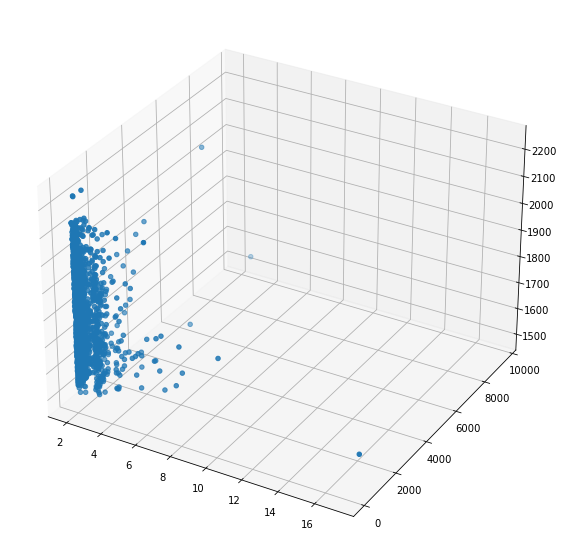

In [36]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(md_df.iloc[:,0],md_df.iloc[:,1],md_df.iloc[:,2])

## Dimention reduction

In [18]:
dim_df = pd.read_csv('md_df.csv')
x = dim_df.values
features = dim_df.columns

In [19]:
from sklearn import decomposition
from sklearn import preprocessing

pca = decomposition.PCA(n_components = 2)
scaler = preprocessing.StandardScaler()
x_scale = scaler.fit_transform(x)

pca.fit(x_scale)

PCA(n_components=2)

In [21]:
scree = (pca.explained_variance_ratio_*100).round(2).cumsum()
print(scree)

[40.21 72.79]


In [32]:
pd.DataFrame(pca.components_, columns = features, index = ['F1', 'F2'])



,n_order,payment_total,days_since_last_order
F1,0.677291,0.661748,-0.321507
F2,0.171745,0.282714,0.943703


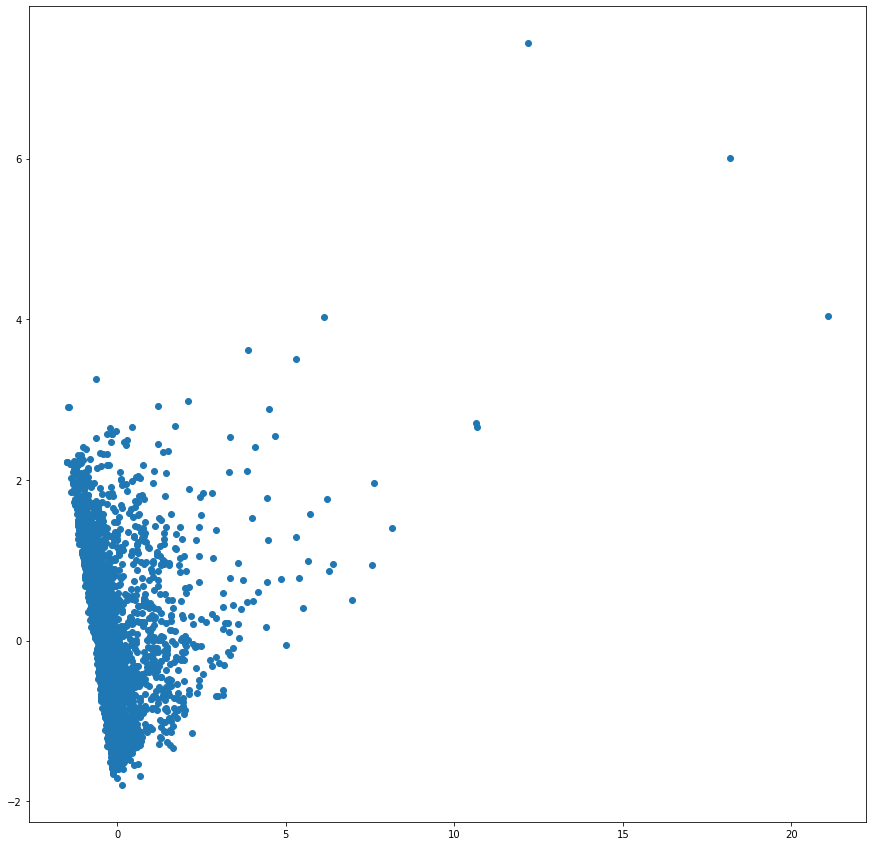

In [26]:
x_proj = pd.DataFrame(pca.transform(x_scale))
fig, ax = plt.subplots(figsize = (15,15))
ax.scatter(x_proj[0],x_proj[1])
plt.show()